EOF
Top-1024,Sketch:8*2688
Execution time:  31.393 seconds.
Precision:  0.862
Sk_head with 1776 bytes.
Total size 124872 bytes, 


lhh_are:0.813643385253392,lhh_aae:257.375
lhh over_estimate:0, lhh under_estimate:2059
sketch over_estimate:10270, sketch under_estimate:1368534
Find:883, TP:883, FP:141
Top_ARE: 0.042127
Top_AAE: 25.593431
all_ARE: 0.512630
all_AAE: 7.814046
Estimate time:   1.348 seconds.


lhh_are:0.624678247897605,lhh_aae:201.625
lhh over_estimate:0, lhh under_estimate:1613
sketch over_estimate:954281, sketch under_estimate:817955
Find:883, TP:883, FP:141
Top_ARE: 0.042127
Top_AAE: 25.593431
all_ARE: 3.566916
all_AAE: 10.043729
Estimate time:   2.761 seconds.


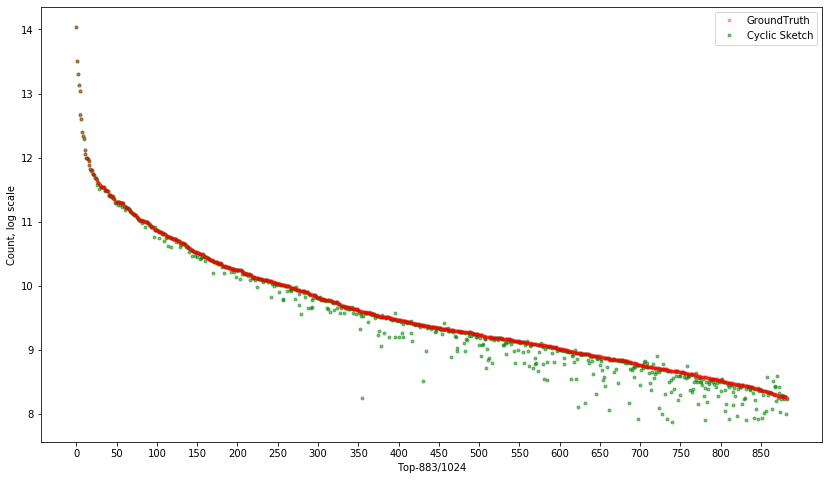

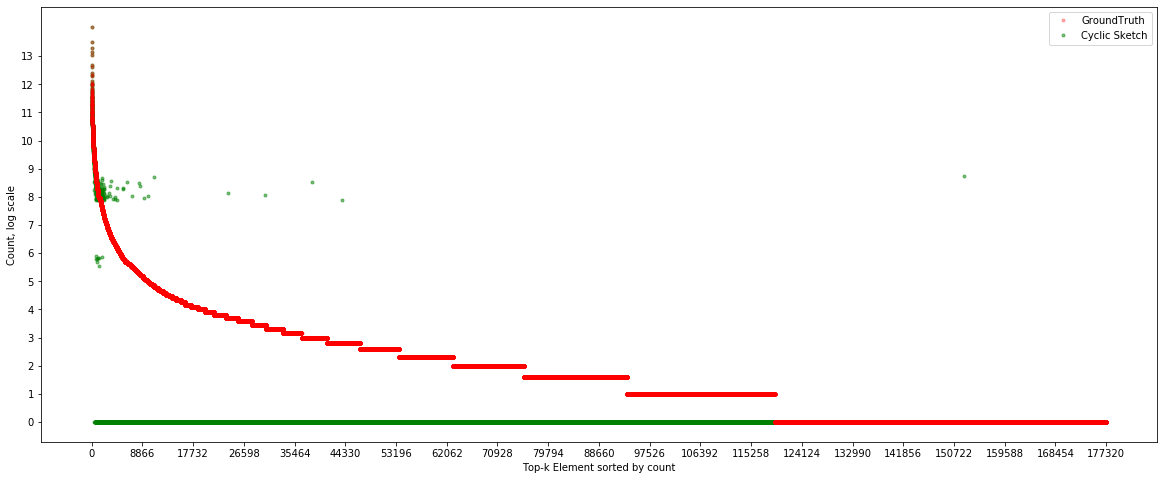

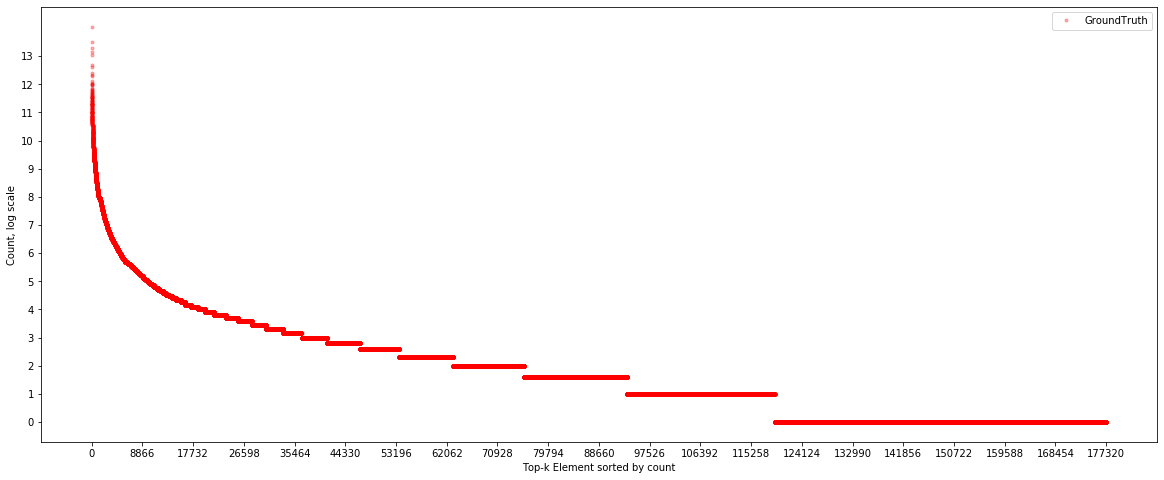

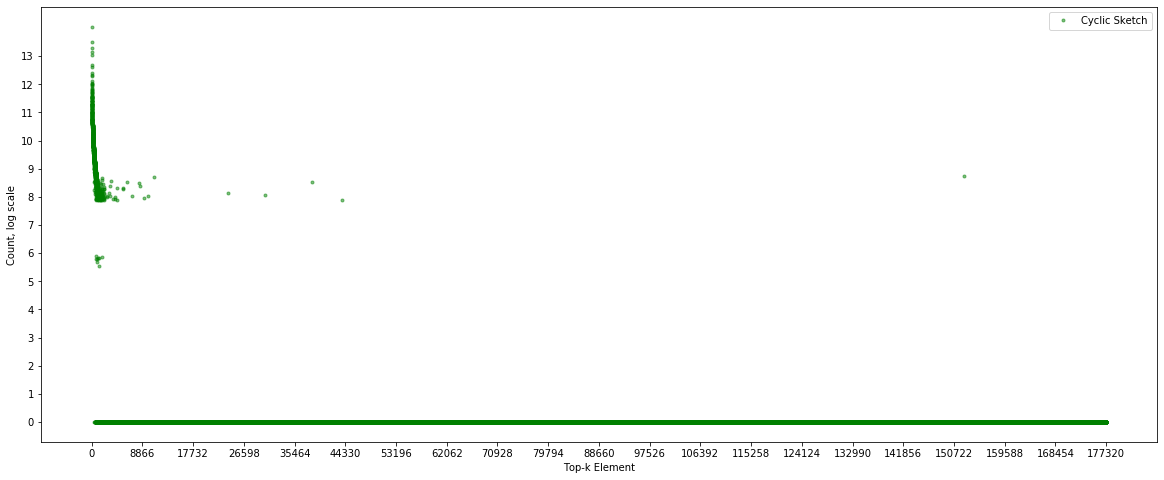

In [1]:
# 20210901 rewrite

from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys

import re

# set dataset and ground truth file path    
filepath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# Top and Sketch parameter config
w=2688
d=8
size=1024
topk=1024
Config.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth

# Initialize Top, Sketch and Sk_head
Sk_head=[DS.Head(0) for j in range(Config.depth)]
Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

# Stream processing
start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:    
                item=DS.Tail(e,1)
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<Config.size:
                        Top_dict[item.ID]=1
                    else:
                        Func.UpdateSk(item,Sk_head,Sketch)
            if Config.e_max.count>e_min.count:
                min_ele = min(Top_dict, key=Top_dict.get)
                    # 找dict中的最小key元素
                e_min=DS.Tail(min_ele,Top_dict[min_ele])
                Func.BringBack(e_min,Top_dict,Sk_head,Sketch)
end=time.time()
print("Top-{},Sketch:{}*{}".format(Config.size,Config.depth,Config.width))
print("Execution time:{:8.3f} seconds.".format(end-start))
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,Config.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))

sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*Config.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE


startx=time.time()
print("\n")
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,9)
endx=time.time()
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx)) 

startx=time.time()
print("\n")
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,10)
endx=time.time()
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx)) 


Func.Plot_topk_compare(gr_path,Top_dict,"Cyclic Sketch")

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=Func.single_query(item,Top_dict,Sk_head,Sketch,cardinality)

Func.Plot_all_compare(ground_truth,My_result,"Cyclic Sketch")

In [ ]:
from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys

import re


def main():
    # set dataset and ground truth file path    
    filepath=r"..\dataset\caida"
    pattern='\w+.dat$'
    r=re.compile(pattern)
    filelist=list(filter(r.match,os.listdir(filepath)))    
        # dataset file list
    
    gr_file_name='caida_0_ground_truth.csv'
    gr_path=os.path.join(filepath,gr_file_name)
        # ground truth path
        
    # Top and Sketch parameter config
    w=1024
    d=1024
    size=1024
    Config.Set_default(w,d,size)
        # set width, depth, size of Sk, random seed of hash,e_max
    
    # Initialize Top, Sketch and Sk_head
    Sk_head=[DS.Head(0) for j in range(Config.depth)]
    Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
    Top_dict=dict()
    e_min=DS.Tail("",1)
    
    # Stream processing
    start=time.time()
    for datafile in filelist[:1]:
        src_data=os.path.join(filepath,datafile)
        with open(src_data,'rb') as file:
             #以binary讀取，資料型態也為byte
            while True:
                e=str(file.read(13))
                if len(e)<13:
                    print('EOF')
                    break
                else:    
                    item=DS.Tail(e,1)
                    if Top_dict.get(item.ID):
                        # e in Top
                        Top_dict[item.ID]+=1
                    else:
                        if len(Top_dict)<Config.size:
                            Top_dict[item.ID]=1
                        else:
                            Func.UpdateSk(item,Sk_head,Sketch)
                if Config.e_max.count>e_min.count:
                    min_ele = min(Top_dict, key=Top_dict.get)
                        # 找dict中的最小key元素
                    e_min=DS.Tail(min_ele,Top_dict[min_ele])
                    Func.BringBack(e_min,Top_dict,Sk_head,Sketch)
    end=time.time()
    print("Top-{},Sketch:{}*{}".format(Config.size,Config.depth,Config.width))
    print("Execution time:{:8.3f} seconds.".format(end-start))
    Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
    
    # Element-Precision
    tp_set,precision=Func.Get_precision(gr_path,Top_dict)

    # Count ARE/AAE

    startx=time.time()
    top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,4)
    endx=time.time()
    print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
    print("Top_ARE: {:8.6f}".format(top_are))
    print("Top_AAE: {:8.6f}".format(top_aae))
    print("all_ARE: {:8.6f}".format(all_are))
    print("all_AAE: {:8.6f}".format(all_aae))
    print("Estimate time:{:8.3f} seconds.".format(endx-startx))    

    startx=time.time()
    top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,5)
    endx=time.time()
    print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
    print("Top_ARE: {:8.6f}".format(top_are))
    print("Top_AAE: {:8.6f}".format(top_aae))
    print("all_ARE: {:8.6f}".format(all_are))
    print("all_AAE: {:8.6f}".format(all_aae))
    print("Estimate time:{:8.3f} seconds.".format(endx-startx))      
    

if __name__=='__main__':
    main()

In [ ]:
from Node import DS
from Tools import Func
from Tools import Config
import pandas as pd
import numpy as np
import os
import time
import operator
import sys

import re

# set dataset and ground truth file path    
filepath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# Top and Sketch parameter config
w=2688
d=8
size=1024
topk=1024
Config.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth

# Initialize Top, Sketch and Sk_head
Sk_head=[DS.Head(0) for j in range(Config.depth)]
Sketch=np.zeros((Config.depth,Config.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

# Stream processing
start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:    
                item=DS.Tail(e,1)
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<Config.size:
                        Top_dict[item.ID]=1
                    else:
                        Func.UpdateSk(item,Sk_head,Sketch)
            if Config.e_max.count>e_min.count:
                min_ele = min(Top_dict, key=Top_dict.get)
                    # 找dict中的最小key元素
                e_min=DS.Tail(min_ele,Top_dict[min_ele])
                Func.BringBack(e_min,Top_dict,Sk_head,Sketch)
end=time.time()
print("Top-{},Sketch:{}*{}".format(Config.size,Config.depth,Config.width))
print("Execution time:{:8.3f} seconds.".format(end-start))
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,Config.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))

sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*Config.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE


startx=time.time()
print("\n")
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,9)
endx=time.time()
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx)) 

startx=time.time()
print("\n")
top_are,top_aae,all_are,all_aae,tp,fp=Func.Get_ARE_AAE(gr_path,Top_dict,Sk_head,Sketch,10)
endx=time.time()
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx)) 


Func.Plot_topk_compare(gr_path,Top_dict)

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=Func.single_query(item,Top_dict,Sk_head,Sketch,cardinality)

Func.Plot_all_compare(ground_truth,My_result)

In [ ]:
print("Sum of Sketch row")
for i in range(len(Sk_head)):
    print(Sk_head[i].count,end=',')
print("\nNumner of distinct elements:")
for i in range(len(Sk_head)):    
    print(len(Sk_head[i].distinct),end=',')
print("\nAvg count for an element in cell:")
for i in range(len(Sk_head)):
    print("{}".format(int(Sk_head[i].count/len(Sk_head[i].distinct))),end=',')
        # int()會無條件捨去

In [ ]:
# compare top k
import pandas as pd
import os

filepath=r"..\dataset\caida"
gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)

grtruth=pd.read_csv(gr_path)
grtruth['Element'] = grtruth['Element'].astype(str)
gt_dict=dict(grtruth[:Config.size].values.tolist())
gt_dict

tp_set=Top_dict.keys() & gt_dict.keys()
print("Top_dict vs. gt_dict:")
smaller=0
bigger=0
for item in tp_set:
    if Top_dict[item]<gt_dict[item]:
        smaller+=1
        print("item:{}:".format(item))
        print('count:{},{}'.format(Top_dict[item],gt_dict[item]))
    elif Top_dict[item]>gt_dict[item]:
        bigger+=1
        #print("item:{}:".format(item))
        #print('count:{},{}'.format(Top_dict[item],gt_dict[item]))        
print(smaller)


In [ ]:
# kargs 的用法
def d(**kargs):
    print(kwargs)
    
d(a=1,b=2)

In [ ]:
filepath=r"..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

distinct=set()
item_count=0

start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:
                item_count+=1
                if e not in distinct:
                    # e in Top
                    distinct.add(e)
    print(len(distinct))
    print(item_count)
end=time.time()